# Ambien't

scp -r mschmitz1@wynlog2.cc.ucsf.edu:/netapp/home/mschmitz1/figs  /home/mt/Downloads/
scp MultiseqVelocyto.py mschmitz1@wynlog2.cc.ucsf.edu:/netapp/home/mschmitz1/pyscripts/
scp VariationalBayesELALDA.py mschmitz1@wynlog2.cc.ucsf.edu:/netapp/home/mschmitz1/pyscripts/

In [1]:

%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems

import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
theano.config.compute_test_value = 'off'
theano.config.profile = True 
theano.config.profile_memory = True 

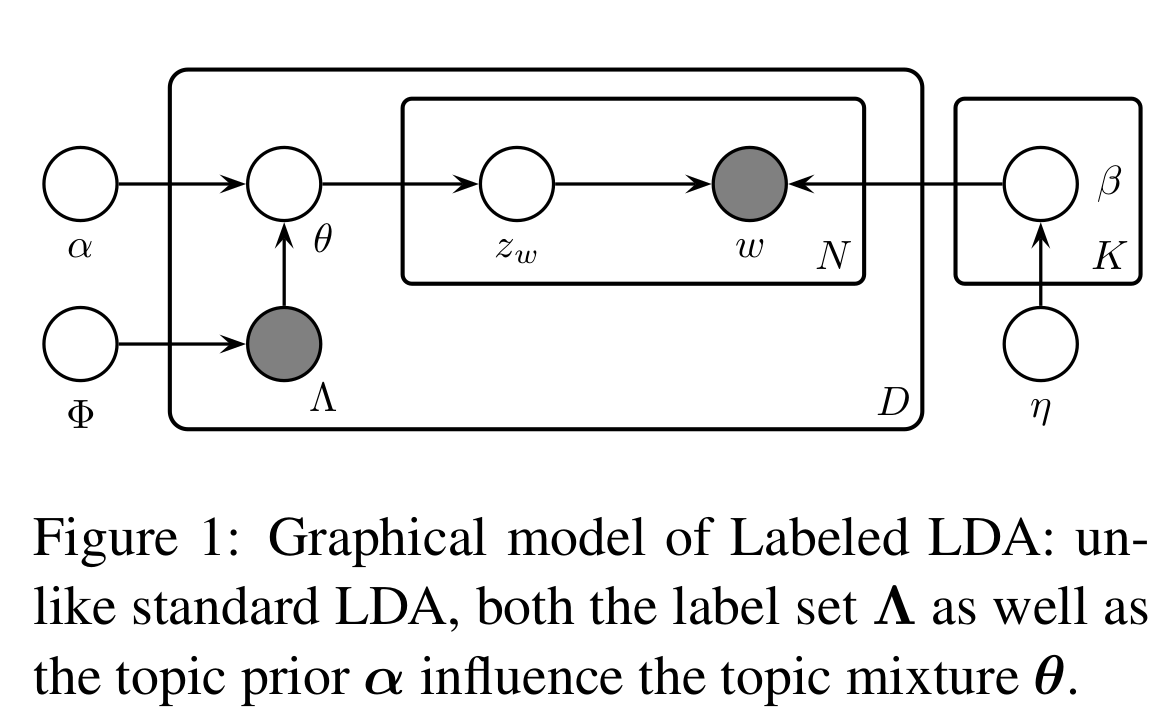

In [3]:
import scanpy as sc
import pandas as pd
maxgenes=3000
adatapath=os.path.expanduser('~/Downloads/E40_motor_Out')
genomename="refdata-celranger-mmul8-toplevel"
samplename='E40'
adata = sc.read_10x_mtx(os.path.join(adatapath,'outs/raw_gene_bc_matrices',genomename),cache=True)
bcs=list(pd.read_csv(os.path.join(adatapath,'outs/filtered_gene_bc_matrices',genomename,'barcodes.tsv')).iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=100,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
adata=adata[adata.obs.n_counts.argsort(),:]


In [5]:
#adata._inplace_subset_obs(np.random.choice(adata.obs.index,10000,replace=False))
#adata._inplace_subset_var(np.random.choice(adata.var.index,4000,replace=False))
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#sc.pp.filter_cells(adata,min_counts=5,inplace=True)

In [4]:
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]
adata._inplace_subset_obs(cell_inds)

In [7]:
freshadata=adata.copy()

In [8]:
adata=adata[:,(-adata[junk_inds,:].X).sum(0).A1.argsort()[0:maxgenes]]

In [9]:
from scipy.stats import gaussian_kde
ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].obs.n_counts)

def from_epdf(param, ambient_counts):
    smin, smax = np.min(ambient_counts), np.max(ambient_counts)
    width = smax - smin
    x = np.linspace(smin, smax, 200)
    y = gaussian_kde(ambient_counts)(x)
    x = np.concatenate([[-1e9,-100,0], x, [x[-1] + np.log10(10)]])
    y = np.concatenate([[1e-1000,1e-200,1e-2], y, [1e-20]])
    #print(x)
    #print(y)
    sns.scatterplot(x,y)
    plt.show()
    return Interpolated(param, x, y)

In [10]:
betaAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()

In [11]:
feature_names=list(adata.var.index)
tf=adata.X[cell_inds,:]


In [12]:
n_samples_tr = tf.shape[0]
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 1140
Number of docs for test = 0
Number of tokens in training set = 10354636.0
Sparsity = 0.591662865497076


1140 3000


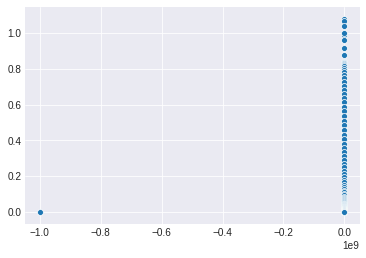

l __str__ = -43881257.26997053
l __str__ = -78819450.6493525
l __str__ = [[2.55218135 2.54145444 2.53491412 ... 3.69518388 3.7399598  3.74147465]]
l __str__ = [[-2.78133751 -2.72754364 -2.69429824 ... -7.52207423 -9.09401386
  -9.14383063]]
l __str__ = -43881257.26997053
l __str__ = -78819450.6493525
l __str__ = [[2.55218135 2.54145444 2.53491412 ... 3.69518388 3.7399598  3.74147465]]
l __str__ = [[-2.78133751 -2.72754364 -2.69429824 ... -7.52207423 -9.09401386
  -9.14383063]]
l __str__ = -43881257.26997053
l __str__ = -78819450.6493525
l __str__ = [[2.55218135 2.54145444 2.53491412 ... 3.69518388 3.7399598  3.74147465]]
l __str__ = [[-2.78133751 -2.72754364 -2.69429824 ... -7.52207423 -9.09401386
  -9.14383063]]


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
Average Loss = 9.947e+07:   6%|▌         | 60/1000 [01:43<26:46,  1.71s/it] 
Interrupted at 60 [6%]: Average Loss = 9.8831e+07


In [13]:
model1 = pm.Model()
K=10
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))
beta = np.ones((1, V))
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))

def log_lda(theta, phi, value):
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')])+ tt.log(phi.T[value[:,1].astype('int32')]),axis=1).ravel()                                                                  
    return tt.sum(ll) 
     
def log_lda(theta, phi,ambient,value,rowsums,sumall,betaAmbient=None):
    if betaAmbient is not None:
        phi=tt.concatenate([phi,betaAmbient],axis=0)
    else:
        phi=phi
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    ambientll=ambient.distribution.logp(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
    tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
    tt.printing.Print('l')(ambient.distribution.logp(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9))))
    return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    #return tt.sum(ll)/sumall + tt.sum(ambientll)/rowsums.shape[1]
    
with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
    ambient=from_epdf('ambient',ambient_counts)
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,betaAmbient=betaAmbient,rowsums=rowsums,sumall=sumall))

#print(model1.profile(model1.logpt).summary())
    
eta = .5
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/2)+1)**.5)    
with model1:    
    inference = pm.ADVI()
    approx = pm.fit(n=1000,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[reduce_rate,pm.callbacks.CheckParametersConvergence(diff='absolute')])
   
#inference    
#pm.plots.traceplot(tr1);    
#pm.plot_posterior(tr1, color='LightSeaGreen')

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/gof/vm.py:887: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')


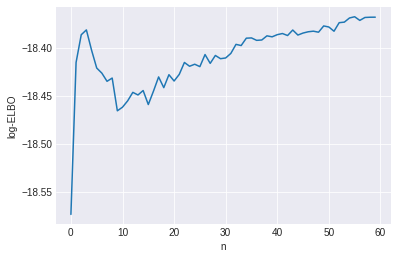

In [14]:
tr1 = approx.sample(draws=1000)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})

sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
theta=tr1['theta'].mean(0)

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


Trying to set attribute `.obs` of view, making a copy.


MemoryError: 

In [ ]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])


In [ ]:
for i in range(theta.shape[1]):
    adata.obs['lda_'+str(i)]=theta[:,i]


In [ ]:
sc.pl.umap(adata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'])


In [ ]:
sc.settings.figdir='/home/mt/Downloads/'
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'scores']})
df.to_csv(os.path.join(sc.settings.figdir,samplename+"BeforeleidenLogRegMarkers.csv"))

In [ ]:
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in adata.var.index[::-1]]


In [ ]:
freshadata=freshadata[:,fullinds]

In [ ]:
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i]
freshadata._inplace_subset_obs([x<.5 for x in freshadata.obs['lda_9']])

In [ ]:
beta=tr1['phi'].mean(0)

In [3]:
sns.distplot(theta[:,theta.shape[1]-1])

NameError: name 'sns' is not defined

In [ ]:
for c in tqdm(range(freshadata.shape[0])):
    vals=[]
    pvals=[]
    for i in range(freshadata.shape[1]):
        vals=vals+[i]*int(freshadata.X[c,i])
        pvals=pvals+[betaAmbient.A1[i]]*int(freshadata.X[c,i])
    if len(vals)>0:
        cellcount=np.sum(freshadata[c,:].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1]*cellcount)),p=pvals/sum(pvals))) 
        freshadata.X[c,list(countremove.keys())]-=np.array(list(countremove.values()))


In [ ]:
freshadata.write(os.path.join(adatapath,'outs/ambientsubtracted.h5ad'))

In [ ]:
sc.pp.filter_genes(freshadata,min_counts=1,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=100,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=3000,inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'])


In [ ]:
sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'])


In [ ]:
sc.tl.rank_genes_groups(adata_copy, 'leiden', method='logreg')
result = adata_copy.uns['rank_genes_groups']
groups = result['names'].dtype.names
df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'scores']})
df.to_csv(os.path.join(sc.settings.figdir,samplename+"AfterleidenLogRegMarkers.csv"))


In [104]:
import sklearn
ldaM=sklearn.decomposition.LatentDirichletAllocation(n_components=10,learning_method="online",verbose=1,n_jobs=-1)
ldaM.fit(tf)
doc_topic=ldaM.transform(tf)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [19]:
def logp_lda_doc(doc_t,theta,beta,density,betaAmbient=None):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    dixs : which doc
    vixs : which word
    vfreqs : frequency of doc x word
    """
    def ll_docs_f(inds):
        inds=inds.eval().astype('int32')
        docs=shared(doc_t[inds,:].toarray())
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        subtheta=theta[inds,:]
        if betaAmbient is not None:
            boundBeta=tt.concatenate([beta,betaAmbient],axis=0)
        else:
            boundBeta=beta
        
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log10(subtheta[dixs]) + tt.log10(boundBeta.T[vixs]),
            axis=1).ravel()
        tt.printing.Print('logsum+theta')(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*subtheta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1])
        #return((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens))
        return ((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10((tt.sum(docs,axis=1)+1e-9)*subtheta[:,theta.shape[1]-1])))))
    
    return ll_docs_f


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


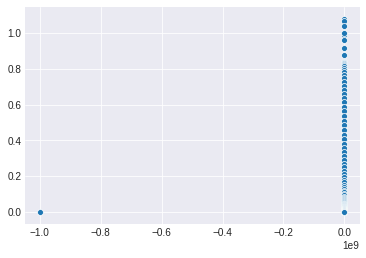

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


logsum+theta __str__ = [-3.06844565 -6.44145892 -5.77898257 -3.38848967 -3.03324084 -3.56272876
 -3.32735764 -3.82768155 -3.07063954 -4.82700929 -4.58108152 -4.98334749
 -3.62626116 -3.03324084 -3.21931101 -6.32082591 -3.23176084 -5.63358317
 -5.28001718 -5.52337508 -4.99222979 -3.73555327 -3.40207932 -4.12349614]
logsum+theta __str__ = [-3.47590882 -3.64352189 -3.96321503 -3.76989077 -5.75575122 -4.34619584
 -3.11003409 -6.47844049 -3.8337247  -5.76007943 -4.29138768 -3.77965262
 -3.12694722 -2.9150111  -3.31642649 -3.34995876 -3.2938513  -3.30433081
 -4.0669164  -4.42349599 -5.04075702 -3.47485977 -4.33203288 -2.98405782]
logsum+theta __str__ = [-3.91604714 -3.98194626 -2.97460012 -5.34674116 -5.00605761 -2.94402628
 -4.10076687 -4.33372708 -2.98405782 -2.92656187 -4.46243307 -4.04560865
 -4.0669164  -2.94402628 -4.99222979 -2.94344141 -4.33146847 -3.16134704
 -3.96118235 -4.31008403 -4.92761396 -3.49278504 -2.94402628 -6.40322698]


In [20]:
n_topics = 10
# we have sparse dataset. It's better to have dense batch so that all words occur there
minibatch_size = 24
n_words=tf.shape[1]

# defining minibatch
#Can't load these arrays
doc_t_minibatch = pm.Minibatch(list(range(docs_tr.shape[0])), minibatch_size)

doc_t = np.random.choice(list(range(docs_tr.shape[0]-1)),minibatch_size-2)
#print(list(doc_t)+[0])
doc_t=[0,docs_tr.shape[0]-1]+list(doc_t)
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((docs_tr.shape[0], n_topics))),
                      shape=(docs_tr.shape[0], n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_samples_tr)    

    beta = Dirichlet('beta', a=pm.floatX((1.0 / (n_topics-1)) * np.ones((n_topics-1, n_words))),
                     shape=(n_topics-1, n_words), transform=t_stick_breaking(1e-9))
    ambient=from_epdf('ambient',ambient_counts)
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(docs_tr,theta,beta,ambient,shared(betaAmbient)), observed=doc_t_minibatch)
    #doc = pm.DensityDist('doc', logp_lda_doc(docs_tr,theta,beta,ambient), observed=doc_t_minibatch)

In [21]:
doc_t=shared(doc_t)

In [22]:
#https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
η = .5
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.5)
with model:
    #step = pm.Metropolis()
    #start = pm.find_MAP(model=model,progressbar=True)
    #step = pm.NUTS()
    #trace=pm.sample(draws=1000, progressbar=True)
    #approx = pm.fit(100, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    #approx = pm.MeanField(local_rv=local_RVs)
    #approx.scale_cost_to_minibatch = False
    #inference = pm.KLqp(approx)
    advi=pm.ADVI()
    advi_fit=advi.fit(n=5000,obj_optimizer=pm.adam(learning_rate=0.1),more_replacements={doc_t: doc_t_minibatch})



  0%|          | 0/5000 [00:00<?, ?it/s]/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 1.7787e+07:  23%|██▎       | 1155/5000 [00:49<02:53, 22.15it/s]
Interrupted at 1,157 [23%]: Average Loss = 1.7847e+07


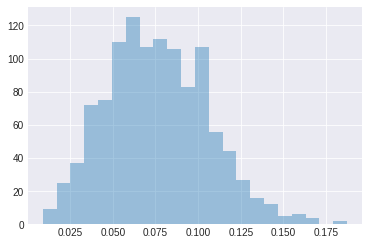

In [24]:
sns.distplot(np.mean(advi_fit.sample(50)['theta'],axis=0)[:,9],kde=False)


In [30]:
theta=advi_fit.sample(1)['theta'][0]
theta

array([[8.50472198e-05, 9.04436554e-03, 1.68264294e-03, ...,
        1.97221699e-05, 3.91562150e-03, 6.91179318e-04],
       [2.07520189e-04, 1.04185846e-03, 1.72017165e-04, ...,
        1.00567526e-09, 6.19338472e-01, 3.79172557e-01],
       [1.83973520e-04, 6.96598123e-05, 1.84813402e-06, ...,
        2.58958009e-03, 3.89961801e-03, 4.16477481e-10],
       ...,
       [1.82261245e-03, 7.59314496e-03, 1.54134042e-01, ...,
        3.91531851e-07, 9.21948554e-03, 1.65140758e-05],
       [7.09451251e-05, 2.07628876e-06, 7.03775933e-01, ...,
        1.34033431e-03, 4.33851966e-08, 3.24237884e-05],
       [1.03442280e-07, 9.98757609e-01, 1.07026816e-05, ...,
        8.66518636e-05, 1.26003158e-05, 7.30901914e-08]])

In [33]:
theta=np.mean(advi_fit.sample(500)['theta'],axis=0)
#beta=np.concatenate([beta,betaAmbient],axis=0)
theta.shape

(1140, 10)

In [37]:
theta=tf*beta.T
theta=np.multiply(theta.T,1/theta.sum(axis=1))

In [28]:
theta.shape

(1, 21, 10)

In [50]:
np.corrcoef(beta)

array([[1.        , 0.99889364, 0.99919022, 0.99874102, 0.99911053,
        0.9988606 , 0.99911311, 0.99913003, 0.99902271, 0.99911386],
       [0.99889364, 1.        , 0.99911662, 0.99791145, 0.99918163,
        0.9991395 , 0.99866277, 0.99902209, 0.99903135, 0.99906528],
       [0.99919022, 0.99911662, 1.        , 0.99884524, 0.99914902,
        0.99924458, 0.99913242, 0.9992301 , 0.99910634, 0.99917305],
       [0.99874102, 0.99791145, 0.99884524, 1.        , 0.99850118,
        0.99847752, 0.99901069, 0.99886538, 0.99838232, 0.99846872],
       [0.99911053, 0.99918163, 0.99914902, 0.99850118, 1.        ,
        0.99910957, 0.99899719, 0.99915828, 0.99923174, 0.99917387],
       [0.9988606 , 0.9991395 , 0.99924458, 0.99847752, 0.99910957,
        1.        , 0.99903428, 0.99905789, 0.99906577, 0.99912275],
       [0.99911311, 0.99866277, 0.99913242, 0.99901069, 0.99899719,
        0.99903428, 1.        , 0.99923628, 0.99897226, 0.99906768],
       [0.99913003, 0.99902209, 0.9992301

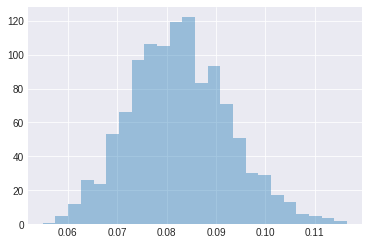

In [111]:
sns.distplot(np.mean(advi_fit.sample(20)['theta'],axis=0)[:,9],kde=False)


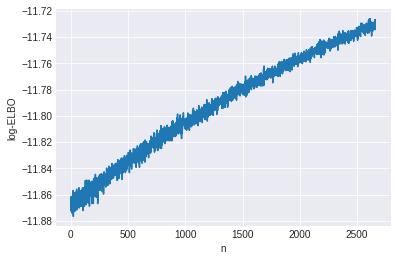

In [30]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [46]:
# import pickle 
with open('/home/mt/Desktop/advimodel.pickle', 'wb') as buff:
    pickle.dump({ 'theta': np.mean(advi_fit.sample(50)['theta'],axis=0)}, buff)

with open('/home/mt/Desktop/advimodel.pickle', 'rb') as buff:
    data = pickle.load(buff)
theta = data['theta']

NameError: name 'pickle' is not defined

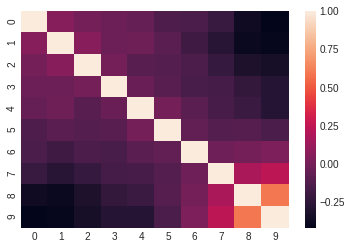

In [65]:
sns.heatmap(np.corrcoef(theta.T))

TypeError: only integer scalar arrays can be converted to a scalar index

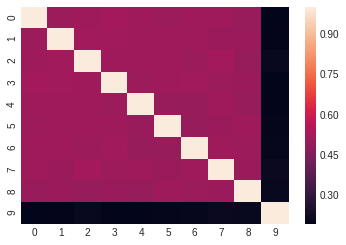

In [63]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


beta_pymc3 = np.concatenate([np.mean(advi_fit.sample(20)['beta'],axis=0),betaAmbient],axis=0)
sns.heatmap(np.corrcoef(beta_pymc3))
print_top_words(beta_pymc3, feature_names)

In [ ]:
sns.distplot(samples['theta'].mean(axis=0)[:,9],kde=False,bins=20)

In [ ]:
samples['theta'].mean(axis=0).shape

In [60]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.nnet.relu(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [62]:
encoder = LDAEncoder(n_words=n_words, n_hidden=1000, n_topics=n_topics, p_corruption=0.0)
print('Built Encoder')
local_RVs = OrderedDict([(theta, encoder.encode(shared(docs_tr[doc_t,:].toarray())))])
doc_t=shared(doc_t)
local_RVs

Built Encoder


OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [63]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

In [67]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000,more_obj_params=encoder_params,more_replacements={doc_t: doc_t_minibatch})

  0%|          | 0/10000 [00:00<?, ?it/s]


IndexError: index 377 is out of bounds for size 24
Apply node that caused the error: AdvancedSubtensor1(theta, TensorConstant{[ 377  375.. 716   54]})
Toposort index: 209
Inputs types: [TensorType(float64, matrix), TensorType(int32, vector)]
Inputs shapes: [(24, 10), (24,)]
Inputs strides: [(8, 192), (4,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Subtensor{::, int64}(AdvancedSubtensor1.0, Constant{9}), AdvancedSubtensor1(AdvancedSubtensor1.0, Subtensor{int64}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-bdb47a819708>", line 24, in <module>
    doc = pm.DensityDist('doc', logp_lda_doc(docs_tr,theta,beta,ambient), observed=doc_t_minibatch)
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 46, in __new__
    return model.Var(name, dist, data, total_size)
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/model.py", line 856, in Var
    total_size=total_size, model=self)
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/model.py", line 1392, in __init__
    self.logp_sum_unscaledt = distribution.logp_sum(data)
  File "/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 123, in logp_sum
    return tt.sum(self.logp(*args, **kwargs))
  File "<ipython-input-58-97458387cb93>", line 23, in ll_docs_f
    subtheta=theta[inds,:]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.